
# Maestria en Explotacion de datos y Descubrimiento de conocimiento

## Aprendizaje Automatico

## Trabajo Practico N°2

### Grupo:

* Adrian Marino
* Alejandro Szpak
* Claudio Collado

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# !sudo apt-get install sox

In [3]:
import sys
sys.path.append('../src')

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Scikitlearn...

from sklearn.ensemble        import RandomForestClassifier, \
                                    AdaBoostClassifier, \
                                    GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, \
                                    RandomizedSearchCV, \
                                    LeaveOneGroupOut, \
                                    KFold


# Librerias propias..

from data   import  Dataset, exclude_columns

from metric import  plot_confusion_matrix, \
                    missing_values_summary, \
                    set_summary, \
                    show_score, \
                    show_cv_score

from sound  import  play, play_audio, \
                    get_functional_feats,\
                    create_new_file_with_noise

#### 1. Cargamos el dataset que ya generamos en la notebook **generar-dataset**.

Este csv representa a todos los archivos de ambos dataset(speechs y songs). La notebook **generar-dataset** descarga ambos datasets y los descompromirlo. Luego recorrer una lista de paths, uno por cada archivo de audio y genera un csv donde las columnas se extraen de la siguiente forma:

* Se toman los features que estan definitos en el nombre del archivo separados por el caracter **-**.
* Se usando la libreria opensmile. Esta extrace features del archivo de audio.

In [4]:
dataset = pd.read_csv('dataset.csv')

In [5]:
dataset.head()

,Unnamed: 0,actor,file_path,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,file,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,0,23,./speech/Actor_23/03-01-04-02-01-01-23.wav,3,1,4,2,1,1,./speech/Actor_23/03-01-04-02-01-01-23.wav,...,0.044101,0.007548,0.015374,1.877934,1.425178,0.251667,0.247482,0.367143,0.419309,-39.951572
1,1,23,./speech/Actor_23/03-01-04-02-02-02-23.wav,3,1,4,2,2,2,./speech/Actor_23/03-01-04-02-02-02-23.wav,...,0.011092,0.008020,0.014090,1.694915,0.856531,0.357500,0.072241,0.634000,0.483429,-42.310856
2,2,23,./speech/Actor_23/03-01-06-02-01-02-23.wav,3,1,6,2,1,2,./speech/Actor_23/03-01-06-02-01-02-23.wav,...,0.101003,0.014311,0.014765,2.339181,0.593472,0.635000,0.335000,0.683333,0.449024,-34.312801
3,3,23,./speech/Actor_23/03-01-07-01-01-02-23.wav,3,1,7,1,1,2,./speech/Actor_23/03-01-07-01-01-02-23.wav,...,0.062009,0.011443,0.021647,2.528090,1.424501,0.180000,0.099800,0.416667,0.422834,-44.573288
4,4,23,./speech/Actor_23/03-01-03-01-01-02-23.wav,3,1,3,1,1,2,./speech/Actor_23/03-01-03-01-01-02-23.wav,...,0.032799,0.011666,0.009868,2.153846,0.625000,0.570000,0.320000,0.670000,0.452548,-36.173256


Audio de un speech:

In [6]:
play(dataset[dataset['vocal_channel'] == 1].iloc[0, :])

Audio Cantado:

In [7]:
play(dataset[dataset['vocal_channel'] == 2].iloc[0, :])

Quitamos columnas que no vamos usar como:

In [8]:
example_columns  = set(dataset.columns) - set([
    'Unnamed: 0',
    'file',
    'modality',
    'statement',
    'repetition',
    'start',
    'end'
])
target_column = 'emotion'

# Esta dos columnas se usan mas adelantes para hacer fold de los actores 
# y luego para agregar ruido a los audios.
special_columns = ['actor', 'file_path']

Luego codificamos **vocal_channel** como dummy y separamos en features de target:

In [9]:
dataset['vocal_channel'].value_counts()

1    1440
2    1012
Name: vocal_channel, dtype: int64

In [10]:
dataset['emotional_intensity'].value_counts()

1    1320
2    1132
Name: emotional_intensity, dtype: int64

In [11]:
def features_target(df):
    df = df[example_columns]
    df['vocal_channel']       = pd.get_dummies(df['vocal_channel'])
    df['emotional_intensity'] = pd.get_dummies(df['emotional_intensity'])
    return exclude_columns(df, [target_column]),  df[[target_column]]

In [12]:
features, target = features_target(dataset)

In [13]:
features['vocal_channel'].value_counts()

1    1440
0    1012
Name: vocal_channel, dtype: int64

In [14]:
features['emotional_intensity'].value_counts()

1    1320
0    1132
Name: emotional_intensity, dtype: int64

Analizamos si hay valores faltantes:

In [15]:
missing_values_summary(features)

Series([], dtype: float64)

Vemos que esta codificado el campo: 0 para speech y 1 para song.

Partimos en dev y test:

In [16]:
random_state = 1
test_size    = 0.3

In [17]:
X_dev, X_test, y_dev, y_test = train_test_split(
    features, 
    target, 
    test_size    = test_size, 
    stratify     = target, 
    random_state = random_state,
    shuffle      = True
)

A continuacion se muestra el porcentaje de ejemplos por clase y si hay valores faltantes:

In [18]:
set_summary(X_dev, y_dev)

- Features shape: (1716, 92)
- Target shape: (1716, 1)
- Target classes:
	- Clase '2': 15.33 %
	- Clase '3': 15.33 %
	- Clase '4': 15.33 %
	- Clase '5': 15.33 %
	- Clase '6': 15.33 %
	- Clase '7': 7.87 %
	- Clase '8': 7.81 %
- Valores faltantes en features: No hay valores faltantes!


In [19]:
set_summary(X_test, y_test)

- Features shape: (736, 92)
- Target shape: (736, 1)
- Target classes:
	- Clase '2': 15.35 %
	- Clase '3': 15.35 %
	- Clase '4': 15.35 %
	- Clase '5': 15.35 %
	- Clase '6': 15.35 %
	- Clase '8': 7.88 %
	- Clase '7': 7.74 %
- Valores faltantes en features: No hay valores faltantes!


#### 2. Ahora vamos a probar modelos con dos estrategias distintas de cross validation.

**Estrategia 1**: 12-fold cross validation armando los folds de forma aleatoria.

In [20]:
cv_strategy_1 = KFold(n_splits=12)

In [21]:
X_Dev_input = exclude_columns(X_dev, special_columns)

Random Forest:

In [22]:
show_cv_score(RandomForestClassifier(), X_Dev_input, y_dev, cv_strategy_1)

Accuracy: 64.9767 %


RandomForestClassifier()

Ada Boost:

In [23]:
show_cv_score(AdaBoostClassifier(), X_Dev_input, y_dev, cv_strategy_1)

Accuracy: 36.3054 %


AdaBoostClassifier()

Gradient Boosting:

In [24]:
%%time
show_cv_score(GradientBoostingClassifier(), X_Dev_input, y_dev, cv_strategy_1)

Accuracy: 64.9184 %
CPU times: user 30.6 ms, sys: 482 µs, total: 31.1 ms
Wall time: 20 s


GradientBoostingClassifier()

XGBoost:

In [25]:
%%time
show_cv_score(XGBClassifier(tree_method='gpu_hist', gpu_id=0), X_Dev_input, y_dev, cv_strategy_1, n_jobs=None)

Accuracy: 65.3263 %
CPU times: user 14.2 s, sys: 203 ms, total: 14.4 s
Wall time: 14.4 s


XGBClassifier(gpu_id=0, tree_method='gpu_hist')

**Estrategia 2**: Leave-2-speakers out. Es decir, 12 folds conteniendo cada uno 2 actores distintos.

La siguiente funcion toma todos los posibles valores de la columna especificada en **input_column** los agrupa en grupos de tamaño **group_size** y luego agrega uni nueva columna (**target_column**) donde se especifica cada fila a que grupo pertenese:

In [26]:
def sample_groups(X, column, group_size):
    numbers = X[column].unique()
    sample  = np.random.choice(numbers, size=len(numbers), replace=False)
    
    return sample.reshape((int(len(numbers) / group_size), group_size))

def set_groups(X, input_column, group_size, target_column):
    tmp = X.copy()

    index = int(max(X[input_column].unique())) + 1
    for group in sample_groups(X, input_column, group_size):
        tmp[target_column] = tmp[input_column].apply(lambda x: index if x in group else x)
        index += 1

    return tmp

In [27]:
sample_groups(X_dev, 'actor', 2)

array([[12, 24],
       [ 7, 13],
       [ 4,  6],
       [16, 11],
       [ 1,  8],
       [17, 21],
       [ 9, 20],
       [19,  3],
       [ 2, 14],
       [10, 18],
       [23, 15],
       [ 5, 22]])

In [28]:
X_dev_tmp = set_groups(
    X_dev, 
    input_column  = 'actor', 
    group_size    = 2, 
    target_column = 'actor'
)
actors_fold_input  = exclude_columns(X_dev_tmp, special_columns)
actors_fold_groups = X_dev_tmp['actor']

Nos quedan 12 grupos de 2 actores cada uno:

In [29]:
len(actors_fold_groups.unique())

12

In [30]:
cv_strategy_2 = LeaveOneGroupOut()

Random Forest:

In [31]:
show_cv_score(RandomForestClassifier(), actors_fold_input, y_dev, cv_strategy_2, actors_fold_groups)

Accuracy: 51.8075 %


RandomForestClassifier()

Ada Boost:

In [32]:
show_cv_score(AdaBoostClassifier(), actors_fold_input, y_dev, cv_strategy_2, actors_fold_groups)

Accuracy: 35.6098 %


AdaBoostClassifier()

Gradient Boosting:

In [33]:
%%time
show_cv_score(GradientBoostingClassifier(), actors_fold_input, y_dev, cv_strategy_2, actors_fold_groups)

Accuracy: 53.4538 %
CPU times: user 24.2 ms, sys: 3.34 ms, total: 27.5 ms
Wall time: 20.4 s


GradientBoostingClassifier()

XGBoost:

In [34]:
%%time
show_cv_score(XGBClassifier(tree_method='gpu_hist', gpu_id=0), actors_fold_input, y_dev, cv_strategy_2, actors_fold_groups, n_jobs=None)

Accuracy: 53.8529 %
CPU times: user 14.1 s, sys: 147 ms, total: 14.2 s
Wall time: 14.3 s


XGBClassifier(gpu_id=0, tree_method='gpu_hist')

#### 3. Realizar la división de datos de la manera que considere más adecuada, teniendo en cuenta el análisis realizado en b), y comparar el desempeño de Random Forests y AdaBoost. Realizar una búsqueda de hiperparámetros para ambos modelos. Para esto, deberá elegirse una métrica de evaluación y justificar la elección. Reportar y analizar la matriz de confusión del mejor modelo, tanto para el caso de audios cantados como hablados.

In [35]:
def model_search(
    model, 
    params_grid, 
    cv, 
    X, 
    y,
    groups  = None, 
    scoring = 'accuracy', 
    n_jobs  = 24, 
    n_iter  = 50, 
    verbose = 1, 
    return_train_score = True
):
    rs = RandomizedSearchCV(
        model,
        params_grid, 
        n_jobs  = n_jobs, 
        scoring = scoring,
        cv      = cv,
        n_iter  = n_iter,
        verbose = verbose,
        return_train_score  = return_train_score
    )
    rs.fit(X, y, groups=groups)
    return rs

In [36]:
X_test_without_special_columns = exclude_columns(X_test, special_columns)

Random Forest:

In [37]:
%%time

ms = model_search(
    model       = RandomForestClassifier(), 
    X           = actors_fold_input, 
    y           = y_dev, 
    cv          = cv_strategy_2,
    groups      = actors_fold_groups,
    params_grid = {
        'criterion': ['gini','entropy'],
        'max_depth': list(range(1, 30)),
        'ccp_alpha': np.linspace(0, 0.5, 100)
    }, 
)
random_forest = show_score(ms.best_estimator_, X_test_without_special_columns, y_test)
random_forest

Fitting 12 folds for each of 50 candidates, totalling 600 fits


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    7.2s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:   18.3s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:   26.1s finished


Accuracy: 55.7065 %
CPU times: user 2.69 s, sys: 37.9 ms, total: 2.72 s
Wall time: 27.3 s


RandomForestClassifier(ccp_alpha=0.015151515151515152, criterion='entropy',
                       max_depth=11)

Ada Boost:

In [38]:
%%time

ms = model_search(
    model       = AdaBoostClassifier(), 
    X           = actors_fold_input, 
    y           = y_dev, 
    cv          = cv_strategy_2,
    groups      = actors_fold_groups,
    params_grid = {
        'n_estimators' : np.arange(10, 20, 1),
        'learning_rate': np.arange(0, 1, 0.001)
    }
)
ada_boost = show_score(ms.best_estimator_, X_test_without_special_columns, y_test)
ada_boost

Fitting 12 folds for each of 50 candidates, totalling 600 fits


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 256 tasks      | elapsed:    3.2s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    6.2s finished


Accuracy: 39.6739 %
CPU times: user 1.06 s, sys: 26.7 ms, total: 1.09 s
Wall time: 6.61 s


AdaBoostClassifier(learning_rate=0.723, n_estimators=19)

Gradient Boosting:

In [39]:
%%time

ms = model_search(
    model       = GradientBoostingClassifier(),  
    X           = actors_fold_input, 
    y           = y_dev, 
    cv          = cv_strategy_2,
    groups      = actors_fold_groups,
    params_grid = {
        'n_estimators' : np.arange(10, 20, 1),
        'learning_rate': np.arange(0, 1, 0.001)
    } 
)
gradient_boosting = show_score(ms.best_estimator_, X_test_without_special_columns, y_test)
gradient_boosting

Fitting 12 folds for each of 50 candidates, totalling 600 fits


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    3.3s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:   26.3s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:  1.1min
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:  1.6min finished


Accuracy: 61.8207 %
CPU times: user 5.19 s, sys: 61.7 ms, total: 5.25 s
Wall time: 1min 38s


GradientBoostingClassifier(learning_rate=0.223, n_estimators=18)

XGBoost:

In [40]:
%%time

ms = model_search(
    model       = XGBClassifier(),  
    X           = actors_fold_input, 
    y           = y_dev, 
    cv          = cv_strategy_2,
    groups      = actors_fold_groups,
    params_grid = {
        'classifier__n_estimators' : np.arange(10, 20, 1),
        'classifier__learning_rate': np.arange(0, 1, 0.0001)
    }
)
xgboost = show_score(ms.best_estimator_, X_test_without_special_columns, y_test)
xgboost

Fitting 12 folds for each of 50 candidates, totalling 600 fits


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    6.7s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:   41.8s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:  1.7min
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:  2.5min finished


Accuracy: 63.1793 %
CPU times: user 5.04 s, sys: 88.6 ms, total: 5.13 s
Wall time: 2min 31s


XGBClassifier(classifier__learning_rate=0.1852, classifier__n_estimators=10,
              objective='multi:softprob')

In [41]:
best_model = xgboost

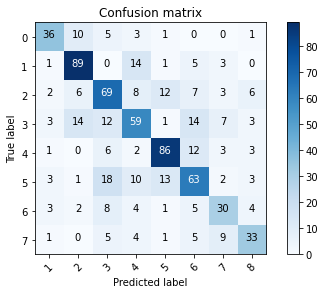

In [42]:
y_pred = best_model.predict(X_test_without_special_columns)
plot_confusion_matrix(y_test, y_pred)

In [43]:
man_actors   = [x for x in features['actor'].unique() if x % 2 == 0]
woman_actors = [x for x in features['actor'].unique() if x % 2 != 0]

In [44]:
def filter_set(X, y, column, values): return X[X[column].isin(values)], y[X[column].isin(values)]

speechs_features, speechs_y_true = filter_set(X_test_without_special_columns, y_test, 'vocal_channel', [0])
songs_features,   songs_y_true   = filter_set(X_test_without_special_columns, y_test, 'vocal_channel', [1])

speechs_features, speechs_y_true = filter_set(X_test_without_special_columns, y_test, 'vocal_channel', [0])
songs_features,   songs_y_true   = filter_set(X_test_without_special_columns, y_test, 'vocal_channel', [1])

man_features, man_y_true     = filter_set(X_test, y_test, 'actor', man_actors)
woman_features, woman_y_true = filter_set(X_test, y_test, 'actor', woman_actors)

man_features = exclude_columns(man_features, special_columns)
woman_features = exclude_columns(woman_features, special_columns)

Audios Cantados vs Hablados:

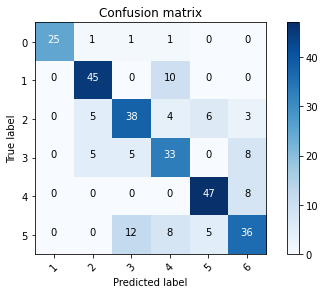

Accuracy: 73.2026 %


XGBClassifier(classifier__learning_rate=0.1852, classifier__n_estimators=10,
              objective='multi:softprob')

In [45]:
y_pred = best_model.predict(speechs_features)

plot_confusion_matrix(speechs_y_true, y_pred)
show_score(best_model, speechs_features, speechs_y_true)

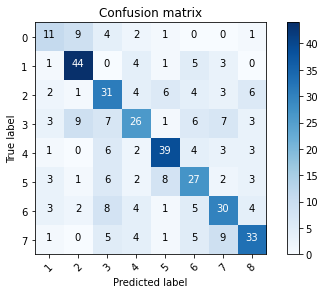

Accuracy: 56.0465 %


XGBClassifier(classifier__learning_rate=0.1852, classifier__n_estimators=10,
              objective='multi:softprob')

In [46]:
y_pred = best_model.predict(songs_features)

plot_confusion_matrix(songs_y_true, y_pred)
show_score(best_model, songs_features, songs_y_true)

Audios de  voces feneninas vs masculinas:

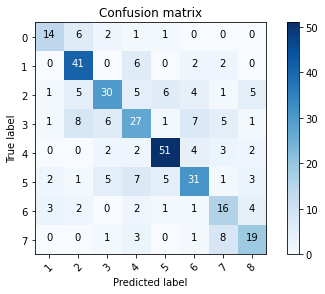

Accuracy: 62.2283 %


XGBClassifier(classifier__learning_rate=0.1852, classifier__n_estimators=10,
              objective='multi:softprob')

In [47]:
y_pred = best_model.predict(woman_features)

plot_confusion_matrix(woman_y_true, y_pred)
show_score(best_model, woman_features, woman_y_true)

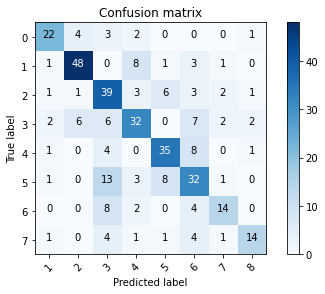

Accuracy: 64.1304 %


XGBClassifier(classifier__learning_rate=0.1852, classifier__n_estimators=10,
              objective='multi:softprob')

In [48]:
y_pred = best_model.predict(man_features)

plot_confusion_matrix(man_y_true, y_pred)
show_score(best_model, man_features, man_y_true)

#### 4. Evaluar la robustez del mejor modelo ante la presencia de ruido en los audios. Realizar una curva que muestre cómo varía una métrica de desempeño para distintas relaciones señal a ruido. El ruido utilizado puede ser sintético (gaussiano por ejemplo), o ruido ambiental. Algunas fuentes de ruido ambiental son:

Comparemos un ejemplo sin ruido contra otro con cierto nivel de ruido:

In [49]:
example_path = X_test['file_path'].values[0]
play_audio(example_path)

Para agregar ruido al audio usamos la funcion **create_new_file_with_noise**. Esta funcion agrega ruido al audio usando la relacion senal ruido(SNR):

In [50]:
noise_example_path = create_new_file_with_noise(example_path, level = 10 ** -4)

print(noise_example_path)
play_audio(noise_example_path)

./speech/Actor_07/noisy/6e4fa532-d241-11eb-9efe-91c257a48e96-03-01-03-02-01-02-07.wav


Redefinimos la funcion que extrae los features de cada audio. Esta nueva funcion agregar ruido al audio antes de extraer sus features.

In [51]:
def feature_extraction_with_noise(file_path, noise_level):
    if noise_level > 0:
        file_path = create_new_file_with_noise(file_path, noise_level)
    return get_functional_feats(file_path)

Comparemos los features con y sin ruido:

In [52]:
feature_extraction_with_noise(noise_example_path, noise_level = 0.0005)

,file,start,end,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,./speech/Actor_07/noisy/noisy/6e54e68c-d241-11...,0 days,0 days 00:00:04.037354167,37.783985,0.045315,35.90992,37.738914,39.59864,3.688721,32.749577,...,0.012372,0.000126,0.424887,2.238806,2.267003,0.121111,0.078803,0.297778,0.409845,-28.109114


In [53]:
feature_extraction_with_noise(noise_example_path, noise_level = 0)

,file,start,end,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,./speech/Actor_07/noisy/6e4fa532-d241-11eb-9ef...,0 days,0 days 00:00:04.037354167,37.072052,0.075763,35.731415,37.196167,39.581539,3.850124,23.256897,...,0.014065,0.00171,0.137578,2.238806,2.015113,0.185,0.081701,0.328571,0.435445,-30.714193


A continuacion vamos a probar cada uno de los modelos del punto 3 evaluandolos en el conjunto de test e inyectando distintos niveles de ruido. De esta manera podemos compara como se comporta cada modelo ante la presencia de ruido. La funcion **plot_noise_vs_accuracy_curve** entrena el modelo para distintos niveles de ruido y grafica cada nivel de ruido vs accuracy.

In [54]:
def generate_noisy_features(example_paths, noise_level):
    examples = Dataset().search_by_paths(
        example_paths, 
        feature_extract_fn = lambda file_path: feature_extraction_with_noise(file_path, noise_level)
    )
    
    X, y = features_target(examples)
    X = exclude_columns(X, special_columns)

    return X, y

def noise_vs_accuracy_metrics(models, example_paths, y_test, noise_levels, model_names):
    accuracy = {n:[] for n in model_names }

    for noise_level in noise_levels:
        X_noise, _ = generate_noisy_features(example_paths, noise_level)
        y_true     = y_test.iloc[X_noise.index.values, :]

        for i, model in enumerate(models):
            acc = model.score(X_noise, y_true)
            accuracy[model_names[i]].append(acc)
            print('Model: {}, SNR: {}, Accuracy: {:.2f} %'.format(model_names[i], noise_level, acc * 100))

    return noise_levels, accuracy

In [55]:
model_names = ['random_forest', 'ada_boost', 'gradient_boosting', 'xgboost']

noise_levels = [10 ** -v for v in range(300, 0, -50)] + [10 ** -v for v in range(9, 0, -1)] + list(range(1, 20, 5))
noise_levels

[1e-300,
 1e-250,
 1e-200,
 1e-150,
 1e-100,
 1e-50,
 1e-09,
 1e-08,
 1e-07,
 1e-06,
 1e-05,
 0.0001,
 0.001,
 0.01,
 0.1,
 1,
 6,
 11,
 16]

In [56]:
test_example_paths = X_test['file_path'].unique()

Realizamos la grafica SNR vs Accuracy usando el conjunto de test:

In [57]:
noise_levels, accuracy = noise_vs_accuracy_metrics(
    [random_forest, ada_boost, gradient_boosting, xgboost],
    test_example_paths, 
    y_test, 
    noise_levels,
    model_names
)

  0%|          | 2/736 [00:00<01:03, 11.49it/s]

Dataset alredy downloaded!


  0%|          | 2/736 [00:00<01:03, 11.51it/s]

Model: random_forest, SNR: 1e-300, Accuracy: 15.30 %
Model: ada_boost, SNR: 1e-300, Accuracy: 15.44 %
Model: gradient_boosting, SNR: 1e-300, Accuracy: 11.89 %
Model: xgboost, SNR: 1e-300, Accuracy: 14.34 %
Dataset alredy downloaded!


  0%|          | 0/736 [00:00<?, ?it/s]

Model: random_forest, SNR: 1e-250, Accuracy: 15.03 %
Model: ada_boost, SNR: 1e-250, Accuracy: 15.44 %
Model: gradient_boosting, SNR: 1e-250, Accuracy: 11.75 %
Model: xgboost, SNR: 1e-250, Accuracy: 15.44 %
Dataset alredy downloaded!


  0%|          | 0/736 [00:00<?, ?it/s]

Model: random_forest, SNR: 1e-200, Accuracy: 15.30 %
Model: ada_boost, SNR: 1e-200, Accuracy: 15.44 %
Model: gradient_boosting, SNR: 1e-200, Accuracy: 11.48 %
Model: xgboost, SNR: 1e-200, Accuracy: 14.62 %
Dataset alredy downloaded!


  0%|          | 0/736 [00:00<?, ?it/s]

Model: random_forest, SNR: 1e-150, Accuracy: 18.31 %
Model: ada_boost, SNR: 1e-150, Accuracy: 17.62 %
Model: gradient_boosting, SNR: 1e-150, Accuracy: 19.13 %
Model: xgboost, SNR: 1e-150, Accuracy: 19.81 %
Dataset alredy downloaded!


  0%|          | 0/736 [00:00<?, ?it/s]

Model: random_forest, SNR: 1e-100, Accuracy: 18.31 %
Model: ada_boost, SNR: 1e-100, Accuracy: 17.62 %
Model: gradient_boosting, SNR: 1e-100, Accuracy: 19.13 %
Model: xgboost, SNR: 1e-100, Accuracy: 19.81 %
Dataset alredy downloaded!


  0%|          | 0/736 [00:00<?, ?it/s]

Model: random_forest, SNR: 1e-50, Accuracy: 18.31 %
Model: ada_boost, SNR: 1e-50, Accuracy: 17.62 %
Model: gradient_boosting, SNR: 1e-50, Accuracy: 19.13 %
Model: xgboost, SNR: 1e-50, Accuracy: 19.81 %
Dataset alredy downloaded!


  0%|          | 0/736 [00:00<?, ?it/s]

Model: random_forest, SNR: 1e-09, Accuracy: 18.44 %
Model: ada_boost, SNR: 1e-09, Accuracy: 17.21 %
Model: gradient_boosting, SNR: 1e-09, Accuracy: 17.76 %
Model: xgboost, SNR: 1e-09, Accuracy: 19.26 %
Dataset alredy downloaded!


  0%|          | 0/736 [00:00<?, ?it/s]

Model: random_forest, SNR: 1e-08, Accuracy: 18.72 %
Model: ada_boost, SNR: 1e-08, Accuracy: 17.76 %
Model: gradient_boosting, SNR: 1e-08, Accuracy: 18.58 %
Model: xgboost, SNR: 1e-08, Accuracy: 18.99 %
Dataset alredy downloaded!


  0%|          | 0/736 [00:00<?, ?it/s]

Model: random_forest, SNR: 1e-07, Accuracy: 18.44 %
Model: ada_boost, SNR: 1e-07, Accuracy: 17.21 %
Model: gradient_boosting, SNR: 1e-07, Accuracy: 18.44 %
Model: xgboost, SNR: 1e-07, Accuracy: 18.99 %
Dataset alredy downloaded!


  0%|          | 0/736 [00:00<?, ?it/s]

Model: random_forest, SNR: 1e-06, Accuracy: 18.31 %
Model: ada_boost, SNR: 1e-06, Accuracy: 16.80 %
Model: gradient_boosting, SNR: 1e-06, Accuracy: 19.26 %
Model: xgboost, SNR: 1e-06, Accuracy: 18.72 %
Dataset alredy downloaded!


  0%|          | 0/736 [00:00<?, ?it/s]

Model: random_forest, SNR: 1e-05, Accuracy: 18.85 %
Model: ada_boost, SNR: 1e-05, Accuracy: 17.62 %
Model: gradient_boosting, SNR: 1e-05, Accuracy: 21.31 %
Model: xgboost, SNR: 1e-05, Accuracy: 19.40 %
Dataset alredy downloaded!


  0%|          | 0/736 [00:00<?, ?it/s]

Model: random_forest, SNR: 0.0001, Accuracy: 18.99 %
Model: ada_boost, SNR: 0.0001, Accuracy: 14.89 %
Model: gradient_boosting, SNR: 0.0001, Accuracy: 17.76 %
Model: xgboost, SNR: 0.0001, Accuracy: 18.85 %
Dataset alredy downloaded!


  0%|          | 2/736 [00:00<01:03, 11.57it/s]

Model: random_forest, SNR: 0.001, Accuracy: 19.26 %
Model: ada_boost, SNR: 0.001, Accuracy: 18.44 %
Model: gradient_boosting, SNR: 0.001, Accuracy: 13.93 %
Model: xgboost, SNR: 0.001, Accuracy: 17.90 %
Dataset alredy downloaded!


  0%|          | 2/736 [00:00<01:04, 11.38it/s]

Model: random_forest, SNR: 0.01, Accuracy: 15.30 %
Model: ada_boost, SNR: 0.01, Accuracy: 17.08 %
Model: gradient_boosting, SNR: 0.01, Accuracy: 11.07 %
Model: xgboost, SNR: 0.01, Accuracy: 13.52 %
Dataset alredy downloaded!


  0%|          | 0/736 [00:00<?, ?it/s]

Model: random_forest, SNR: 0.1, Accuracy: 15.16 %
Model: ada_boost, SNR: 0.1, Accuracy: 15.44 %
Model: gradient_boosting, SNR: 0.1, Accuracy: 11.89 %
Model: xgboost, SNR: 0.1, Accuracy: 15.85 %
Dataset alredy downloaded!


  0%|          | 2/736 [00:00<01:04, 11.46it/s]

Model: random_forest, SNR: 1, Accuracy: 14.89 %
Model: ada_boost, SNR: 1, Accuracy: 15.44 %
Model: gradient_boosting, SNR: 1, Accuracy: 12.02 %
Model: xgboost, SNR: 1, Accuracy: 15.03 %
Dataset alredy downloaded!


  0%|          | 0/736 [00:00<?, ?it/s]

Model: random_forest, SNR: 6, Accuracy: 15.57 %
Model: ada_boost, SNR: 6, Accuracy: 15.44 %
Model: gradient_boosting, SNR: 6, Accuracy: 11.61 %
Model: xgboost, SNR: 6, Accuracy: 14.89 %
Dataset alredy downloaded!


  0%|          | 2/736 [00:00<01:04, 11.42it/s]

Model: random_forest, SNR: 11, Accuracy: 15.57 %
Model: ada_boost, SNR: 11, Accuracy: 15.57 %
Model: gradient_boosting, SNR: 11, Accuracy: 11.89 %
Model: xgboost, SNR: 11, Accuracy: 14.62 %
Dataset alredy downloaded!


100%|██████████| 736/736 [01:07<00:00, 10.94it/s]

Model: random_forest, SNR: 16, Accuracy: 15.57 %
Model: ada_boost, SNR: 16, Accuracy: 15.30 %
Model: gradient_boosting, SNR: 16, Accuracy: 11.48 %
Model: xgboost, SNR: 16, Accuracy: 15.44 %


In [58]:
sns.set_style("white")
sns.despine()
sns.set(rc={'figure.figsize':(20, 10)})

def plot_metrics(noise_levels, accuracy):
    for model_name in accuracy:
        sns.lineplot(noise_levels, accuracy[model_name], label=model_name)
    plt.xlabel('SNR')
    plt.ylabel('Accuracy')
    plt.show()

<Figure size 432x288 with 0 Axes>

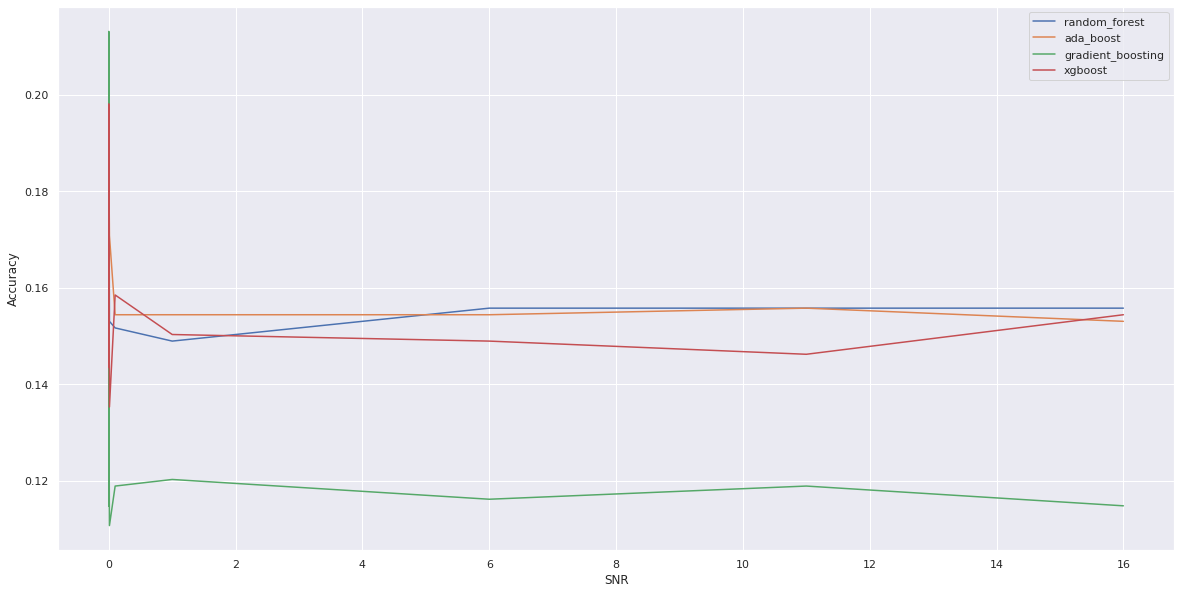

In [59]:
plot_metrics(noise_levels, accuracy)